In [1]:
import numpy as np
import networkx as nx

def cal_all_pairs_minimax_path_matrix_by_algo_4(distance_matrix):
    N = len(distance_matrix)
    all_pairs_minimax_matrix = np.zeros((N, N))

    # Construct Minimum Spanning Tree (MST) from the graph
    MST = construct_MST_from_graph(distance_matrix)
    MST_edge_list = list(MST.edges(data='weight'))

    edge_node_list = [(edge[0], edge[1]) for edge in MST_edge_list]
    edge_weight_list = [edge[2] for edge in MST_edge_list]

    # Sort edges in descending order of weight
    edge_large_to_small_arg = np.argsort(edge_weight_list)[::-1]
    edge_weight_large_to_small = np.array(edge_weight_list)[edge_large_to_small_arg]
    edge_nodes_large_to_small = [edge_node_list[i] for i in edge_large_to_small_arg]

    # Iteratively remove edges and calculate tree nodes
    for i, edge_nodes in enumerate(edge_nodes_large_to_small):
        edge_weight = edge_weight_large_to_small[i]
        MST.remove_edge(*edge_nodes)

        tree1_nodes = list(nx.dfs_preorder_nodes(MST, source=edge_nodes[0]))
        tree2_nodes = list(nx.dfs_preorder_nodes(MST, source=edge_nodes[1]))

        for p1 in tree1_nodes:
            for p2 in tree2_nodes:
                all_pairs_minimax_matrix[p1, p2] = edge_weight
                all_pairs_minimax_matrix[p2, p1] = edge_weight

    return all_pairs_minimax_matrix

def construct_MST_from_graph(distance_matrix):
    G = nx.Graph()
    N = len(distance_matrix)
    for i in range(N):
        for j in range(i + 1, N):
            G.add_edge(i, j, weight=distance_matrix[i][j])
    MST = nx.minimum_spanning_tree(G)
    return MST


In [2]:
def variant_of_Floyd_Warshall(adj_matrix):
    p = adj_matrix.copy()
    N = len(adj_matrix)

    for i in range(N):
        for j in range(N):
            if i != j:
                for k in range(N):
                    if i != k and j != k:
                        p[j, k] = min(p[j, k], max(p[j, i], p[i, k]))
    return p


In [3]:
import numpy as np
import networkx as nx
from collections import defaultdict

def cal_all_pairs_minimax_path_matrix_optimized(distance_matrix):
    N = len(distance_matrix)
    all_pairs_minimax_matrix = np.zeros((N, N))

    # Construct MST more efficiently using numpy array
    MST = construct_MST_from_graph_optimized(distance_matrix)

    # Get edges with weights as a list of tuples (node1, node2, weight)
    edges_with_weights = [(u, v, d['weight']) for u, v, d in MST.edges(data=True)]

    # Sort edges by weight in descending order more efficiently
    sorted_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)

    # Create a union-find data structure for efficient component tracking
    parent = list(range(N))
    rank = [0] * N

    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])  # Path compression
        return parent[x]

    def union(x, y):
        px, py = find(x), find(y)
        if px == py:
            return
        if rank[px] < rank[py]:
            px, py = py, px
        parent[py] = px
        if rank[px] == rank[py]:
            rank[px] += 1

    components = defaultdict(set)
    for i in range(N):
        components[i].add(i)

    # Process edges in descending weight order
    for edge in sorted_edges:
        u, v, weight = edge

        # Get the current components of both nodes
        comp_u = find(u)
        comp_v = find(v)

        # Fill the matrix for all pairs between the two components
        for node1 in components[comp_u]:
            for node2 in components[comp_v]:
                all_pairs_minimax_matrix[node1, node2] = weight
                all_pairs_minimax_matrix[node2, node1] = weight

        # Merge components
        smaller_comp = comp_u if len(components[comp_u]) < len(components[comp_v]) else comp_v
        larger_comp = comp_v if smaller_comp == comp_u else comp_u

        components[larger_comp].update(components[smaller_comp])
        del components[smaller_comp]
        union(u, v)

    return all_pairs_minimax_matrix

def construct_MST_from_graph_optimized(distance_matrix):
    """Constructs MST more efficiently using numpy operations"""
    N = len(distance_matrix)
    G = nx.Graph()

    # Add edges using numpy operations to find non-zero elements
    rows, cols = np.triu_indices(N, k=1)
    weights = distance_matrix[rows, cols]

    # Add edges in bulk
    edges = list(zip(rows, cols, weights))
    G.add_weighted_edges_from(edges)

    return nx.minimum_spanning_tree(G)

# Helper function to verify correctness
def verify_minimax_path_matrix(original_matrix, result_matrix):
    """Verifies that the result matrix correctly represents minimax paths"""
    N = len(original_matrix)
    for i in range(N):
        for j in range(i + 1, N):
            paths = nx.all_simple_paths(nx.Graph(original_matrix), i, j)
            min_max_weight = float('inf')
            for path in paths:
                path_max_weight = max(original_matrix[path[k]][path[k+1]]
                                   for k in range(len(path)-1))
                min_max_weight = min(min_max_weight, path_max_weight)
            assert abs(result_matrix[i][j] - min_max_weight) < 1e-10, \
                   f"Mismatch at ({i},{j}): got {result_matrix[i][j]}, expected {min_max_weight}"
    return True

Testing with graph size: 5


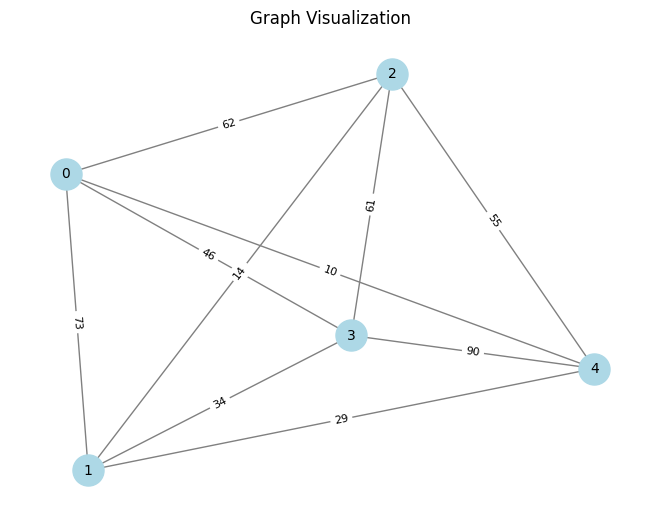

  Correctness: Pass
  Execution Time (seconds) - Algorithm 4: 0.0005, Algorithm Pro: 0.0005
Testing with graph size: 10


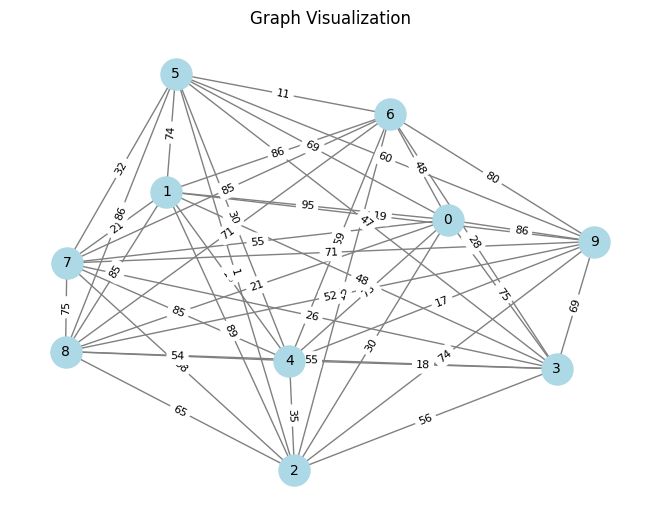

  Correctness: Pass
  Execution Time (seconds) - Algorithm 4: 0.0013, Algorithm Pro: 0.0008
Testing with graph size: 20


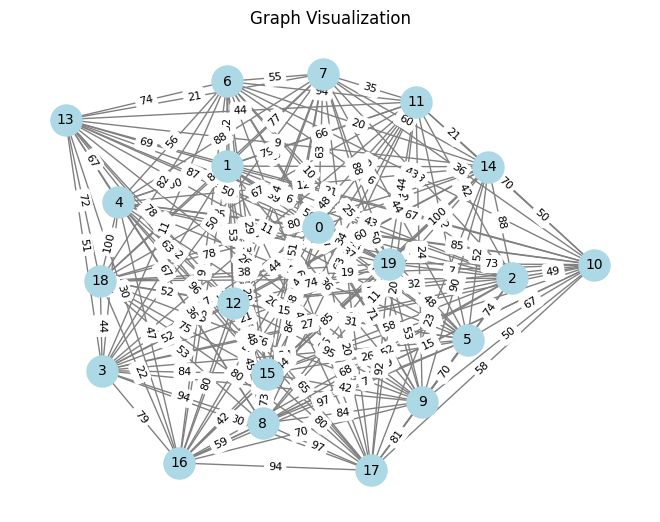

  Correctness: Pass
  Execution Time (seconds) - Algorithm 4: 0.0031, Algorithm Pro: 0.0022
Testing with graph size: 50


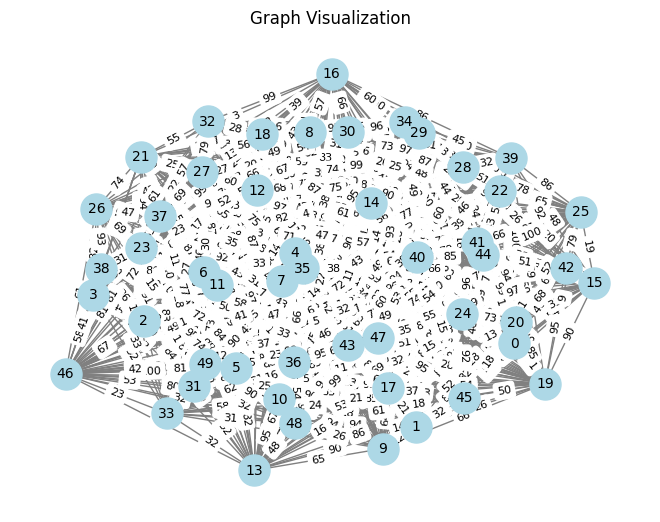

  Correctness: Pass
  Execution Time (seconds) - Algorithm 4: 0.0178, Algorithm Pro: 0.0070
Testing with graph size: 100


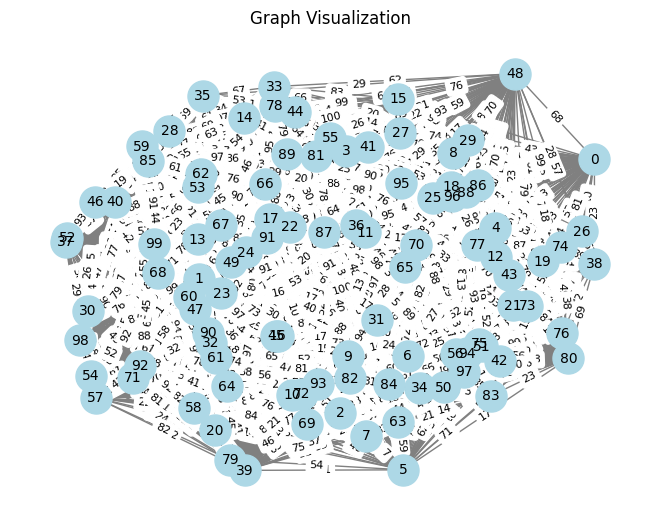

  Correctness: Pass
  Execution Time (seconds) - Algorithm 4: 0.0329, Algorithm Pro: 0.0276

Summary:
+--------------+-----------+------------------+--------------------+
|   Graph Size | Correct   |   Algo4 Time (s) |   AlgoPro Time (s) |
+==============+===========+==================+====================+
|            5 | Pass      |           0.0005 |             0.0005 |
+--------------+-----------+------------------+--------------------+
|           10 | Pass      |           0.0013 |             0.0008 |
+--------------+-----------+------------------+--------------------+
|           20 | Pass      |           0.0031 |             0.0022 |
+--------------+-----------+------------------+--------------------+
|           50 | Pass      |           0.0178 |             0.007  |
+--------------+-----------+------------------+--------------------+
|          100 | Pass      |           0.0329 |             0.0276 |
+--------------+-----------+------------------+--------------------+


In [6]:
from tabulate import tabulate  # Import for table formatting
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt

# Utility function to create random adjacency matrices for undirected weighted graphs
def generate_random_graph(num_nodes, max_weight=100):
    adj_matrix = np.random.randint(1, max_weight + 1, size=(num_nodes, num_nodes))
    adj_matrix = np.triu(adj_matrix, 1)  # Keep only upper triangle
    adj_matrix += adj_matrix.T  # Make it symmetric for undirected graphs
    return adj_matrix

# Visualization function to display the graph
def visualize_graph(adj_matrix):
    G = nx.Graph()
    num_nodes = adj_matrix.shape[0]

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add edges with weights
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i, j] > 0:
                G.add_edge(i, j, weight=adj_matrix[i, j])

    # Draw the graph with weights
    pos = nx.spring_layout(G)  # Position nodes using the spring layout
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Graph Visualization")
    plt.show()

# Check correctness by comparing the two implementations
def check_correctness(adj_matrix):
    algo4_result = cal_all_pairs_minimax_path_matrix_by_algo_4(adj_matrix)
    fw_result = variant_of_Floyd_Warshall(adj_matrix)
    return np.allclose(algo4_result, fw_result)

# Measure execution time for a single test
def measure_execution_time(adj_matrix):
    start_algo4 = time.time()
    cal_all_pairs_minimax_path_matrix_by_algo_4(adj_matrix)
    end_algo4 = time.time()

    start_algopro = time.time()
    cal_all_pairs_minimax_path_matrix_optimized(adj_matrix)
    end_algopro = time.time()

    return end_algo4 - start_algo4, end_algopro - start_algopro

# Run tests with varying graph sizes
def run_tests():
    test_sizes = [5, 10, 20, 50, 100]  # Number of nodes in the graph
    results = []

    for size in test_sizes:
        print(f"Testing with graph size: {size}")
        adj_matrix = generate_random_graph(size)

        # Visualize the graph
        visualize_graph(adj_matrix)

        # Correctness check
        correct = check_correctness(adj_matrix)
        print(f"  Correctness: {'Pass' if correct else 'Fail'}")

        # Execution time measurement
        algo4_times = []
        fw_times = []
        t = 5  # Number of times to measure execution time

        for _ in range(t):
            algo4_time, fw_time = measure_execution_time(adj_matrix)
            algo4_times.append(algo4_time)
            fw_times.append(fw_time)

        # Calculate geometric mean of execution times
        algo4_geo_mean = np.exp(np.mean(np.log(algo4_times)))
        fw_geo_mean = np.exp(np.mean(np.log(fw_times)))

        print(f"  Execution Time (seconds) - Algorithm 4: {algo4_geo_mean:.4f}, Algorithm Pro: {fw_geo_mean:.4f}")

        # Store results
        results.append({
            "size": size,
            "correct": correct,
            "algo4_time": algo4_geo_mean,
            "fw_time": fw_geo_mean
        })

    return results

# Run and display test results
test_results = run_tests()

# Format the results into a table
print("\nSummary:")
headers = ["Graph Size", "Correct", "Algo4 Time (s)", "AlgoPro Time (s)"]
table = [[result['size'],
          "Pass" if result['correct'] else "Fail",
          f"{result['algo4_time']:.4f}",
          f"{result['fw_time']:.4f}"] for result in test_results]
print(tabulate(table, headers=headers, tablefmt="grid"))
